In [16]:
from itertools import islice



from matplotlib import pyplot as plt

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm



import torch

from gluonts.evaluation import make_evaluation_predictions, Evaluator

from gluonts.dataset.repository.datasets import get_dataset



from gluonts.dataset.pandas import PandasDataset

import pandas as pd

# import sys
# sys.path.append("./lag-llama")

from lag_llama.gluon.estimator import LagLlamaEstimator


# Loading Data

In [ ]:
df = pd.read_csv("dataset/Sales_data 1.csv")

df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

df = df.sort_values(['item_id', 'customer', 'date'])

df.head()

,item_id,year,month,week,day,brand,subbrand,customer,sales,date
2,11001,2022,1,1,3,Aveeno,Calm + Restore,Amazon,8793,2022-01-03
3,11001,2022,1,1,4,Aveeno,Calm + Restore,Amazon,8421,2022-01-04
5,11001,2022,1,1,7,Aveeno,Calm + Restore,Amazon,8074,2022-01-07
12,11001,2022,1,2,15,Aveeno,Calm + Restore,Amazon,6208,2022-01-15
17,11001,2022,1,3,23,Aveeno,Calm + Restore,Amazon,7134,2022-01-23


In [18]:
from gluonts.dataset.common import ListDataset
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns for feat_static_cat
item_enc = LabelEncoder().fit(df["item_id"])
# customer_enc = LabelEncoder().fit(df["customer"])
brand_enc = LabelEncoder().fit(df["brand"])

# Optional: Encode brand if you want to include it
# brand_enc = LabelEncoder().fit(df["brand"])

series = []

group_cols = ['item_id', 'brand']
for (item, brand), group in df.groupby(group_cols):
    entry = {
        "start": group["date"].iloc[0],
        "target": group["sales"].tolist(),
        "item_id": f"{item}_{brand}",
        "feat_static_cat": [
            item_enc.transform([item])[0],
            # customer_enc.transform([customer])[0],
            brand_enc.transform([brand])[0]
            # brand_enc.transform([group["brand"].iloc[0]])[0]  # if needed
        ],
    }
    series.append(entry)

train_ds = ListDataset(series, freq="D")

In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from gluonts.dataset.common import ListDataset
from lag_llama.gluon.estimator import LagLlamaEstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import torch

# import torch.serialization
# from gluonts.torch.distributions.studentT import StudentTOutput

# torch.serialization.add_safe_globals([StudentTOutput])


# Load your sales dataframe
# df = pd.read_csv("your_sales_data.csv")  # Replace with your file if needed

# Convert to datetime
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values(['item_id', 'customer', 'date'])

# Encode item_id and customer for feat_static_cat
item_enc = LabelEncoder().fit(df['item_id'])
customer_enc = LabelEncoder().fit(df['customer'])

# Build GluonTS-style dataset
series = []
for (item, customer), group in df.groupby(['item_id', 'customer']):
    entry = {
        "start": group['date'].iloc[0],
        "target": group['sales'].tolist(),
        "item_id": f"{item}_{customer}",
        "feat_static_cat": [
            item_enc.transform([item])[0],
            customer_enc.transform([customer])[0]
        ]
    }
    series.append(entry)

# Set prediction length
prediction_length = 7
context_length = 30

# Build dataset
train_ds = ListDataset(series, freq="D")

# Load pretrained model checkpoint
# ckpt = torch.load("/home/snig/work/lag-llama/lag-llama.ckpt", map_location="cpu")

import torch.serialization
from gluonts.torch.distributions.studentT import StudentTOutput

with torch.serialization.safe_globals([StudentTOutput]):
    ckpt = torch.load("work/lag-llama/lag-llama.ckpt", map_location="cpu", weights_only=False)

hp = ckpt["hyper_parameters"]["model_kwargs"]

# Create the estimator using IBM's method
estimator = LagLlamaEstimator(
    ckpt_path="work/lag-llama/lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=hp["input_size"],
    n_layer=hp["n_layer"],
    n_embd_per_head=hp["n_embd_per_head"],
    n_head=hp["n_head"],
    scaling=hp.get("scaling", None),
    time_feat=hp["time_feat"],
    nonnegative_pred_samples=True,
    rope_scaling={
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / hp["context_length"]),
    },
    batch_size=64,
    num_parallel_samples=20,
)

# Generate predictor
lightning_module = estimator.create_lightning_module()
transform = estimator.create_transformation()
predictor = estimator.create_predictor(transform, lightning_module)

# # Predict
# forecast_it, ts_it = make_evaluation_predictions(
#     dataset=train_ds,
#     predictor=predictor,
#     num_samples=20
# )

# # Evaluate
# evaluator = Evaluator()
# agg_metrics, item_metrics = evaluator(ts_it, forecast_it)
# print("Aggregate metrics:", agg_metrics)


# Generate predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds,
    predictor=predictor,
    num_samples=20
)

# Convert to lists BEFORE evaluation
forecast_list = list(forecast_it)
ts_list = list(ts_it)

# Create fresh iterators for evaluation
forecast_it_eval = iter(forecast_list)
ts_it_eval = iter(ts_list)

# Evaluate
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(ts_it_eval, forecast_it_eval)
print("Aggregate metrics:", agg_metrics)

# Now you can use forecast_list and ts_list for plotting


/home/snig/miniconda3/envs/lag-llama-env/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Running evaluation: 196it [00:0

Aggregate metrics: {'MSE': 39748172.14303936, 'abs_error': 5348460.732421875, 'abs_target_sum': 20107550.0, 'abs_target_mean': 14655.648688046647, 'seasonal_error': 1670.7837084227933, 'MASE': 2.1562807825993193, 'MAPE': 0.22017689257773299, 'sMAPE': 0.23957617741632048, 'MSIS': 37.5637063171525, 'num_masked_target_values': 0.0, 'QuantileLoss[0.1]': 1833337.4754882813, 'Coverage[0.1]': 0.130466472303207, 'QuantileLoss[0.2]': 2948921.15546875, 'Coverage[0.2]': 0.21647230320699704, 'QuantileLoss[0.3]': 3927718.166601563, 'Coverage[0.3]': 0.30612244897959184, 'QuantileLoss[0.4]': 4712562.715234376, 'Coverage[0.4]': 0.37609329446064144, 'QuantileLoss[0.5]': 5348460.7060546875, 'Coverage[0.5]': 0.4380466472303207, 'QuantileLoss[0.6]': 5818535.378515625, 'Coverage[0.6]': 0.47011661807580174, 'QuantileLoss[0.7]': 6025856.927929687, 'Coverage[0.7]': 0.5364431486880467, 'QuantileLoss[0.8]': 5927569.659374999, 'Coverage[0.8]': 0.6027696793002916, 'QuantileLoss[0.9]': 5480412.956640625, 'Coverage

Generating fresh predictions for plotting...
Number of forecasts: 196
Number of time series: 196
Context length: 30
Prediction length: 7
✓ Forecasts generated successfully
196
Plotting 10 series...
Plotting series 1...


/home/snig/miniconda3/envs/lag-llama-env/lib/python3.12/site-packages/gluonts/model/forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


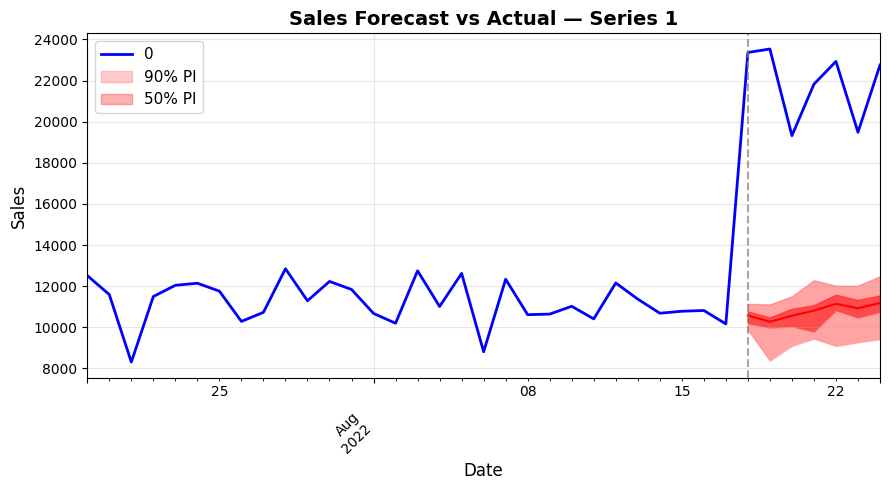

Plotting series 2...


/home/snig/miniconda3/envs/lag-llama-env/lib/python3.12/site-packages/gluonts/model/forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


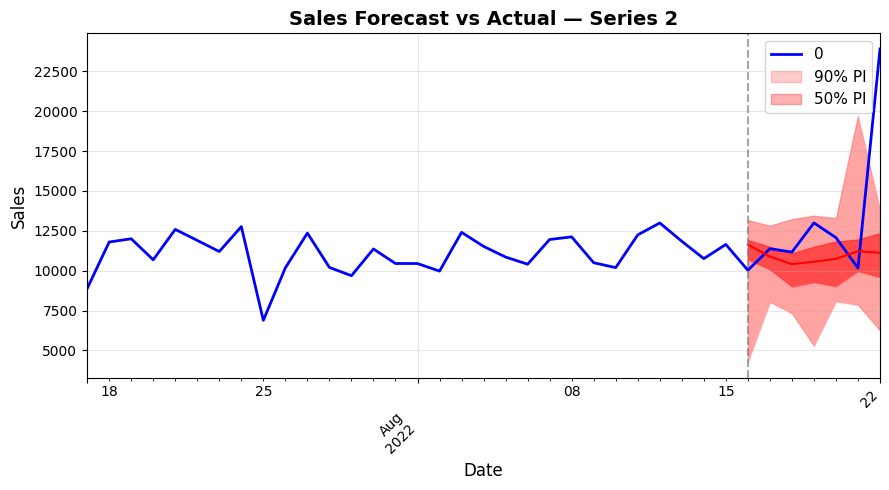

Plotting series 3...


/home/snig/miniconda3/envs/lag-llama-env/lib/python3.12/site-packages/gluonts/model/forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


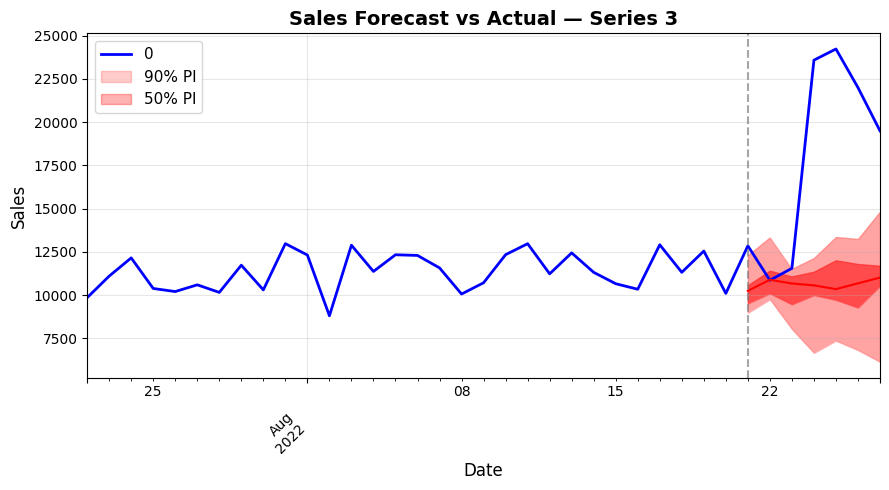

Plotting series 4...


/home/snig/miniconda3/envs/lag-llama-env/lib/python3.12/site-packages/gluonts/model/forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


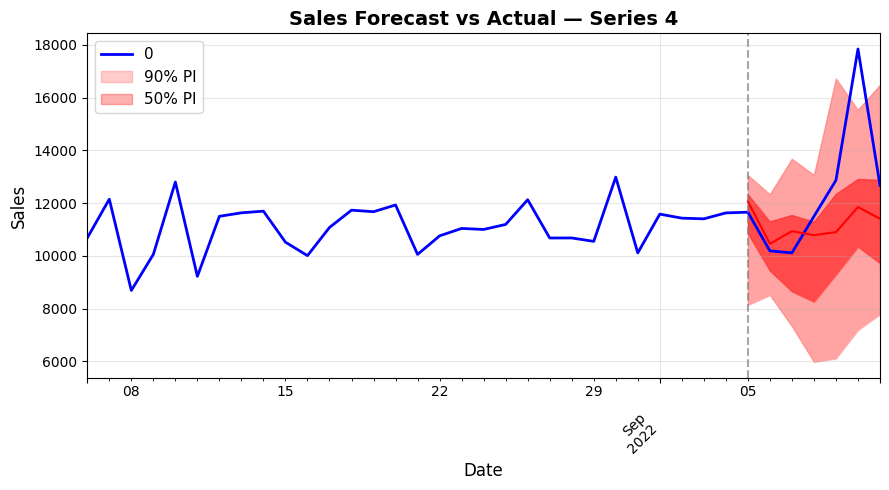

Plotting series 5...


/home/snig/miniconda3/envs/lag-llama-env/lib/python3.12/site-packages/gluonts/model/forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


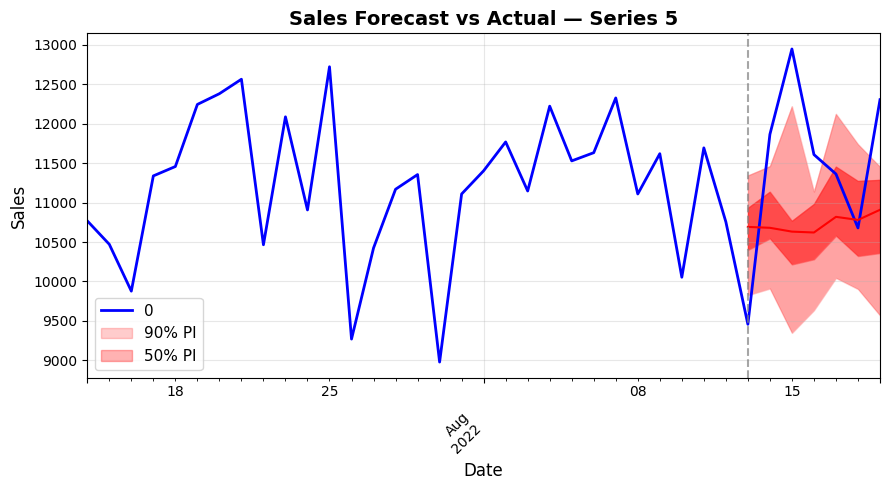

Plotting series 6...


/home/snig/miniconda3/envs/lag-llama-env/lib/python3.12/site-packages/gluonts/model/forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


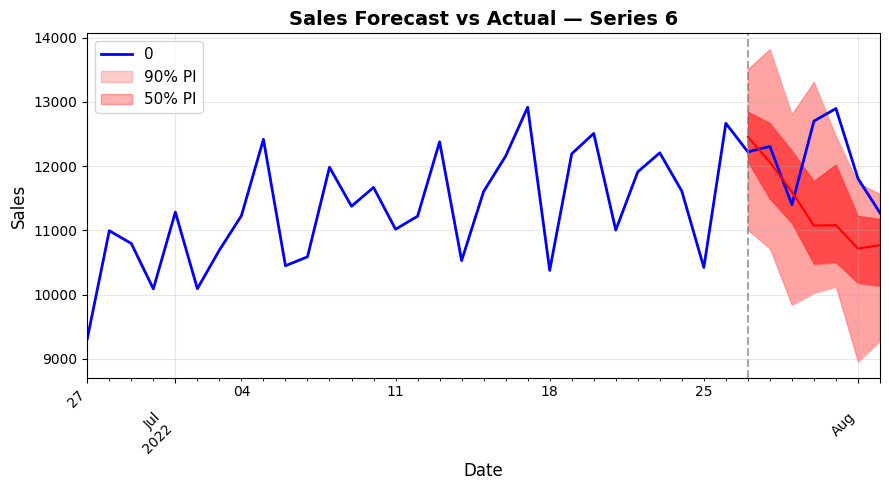

Plotting series 7...


/home/snig/miniconda3/envs/lag-llama-env/lib/python3.12/site-packages/gluonts/model/forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


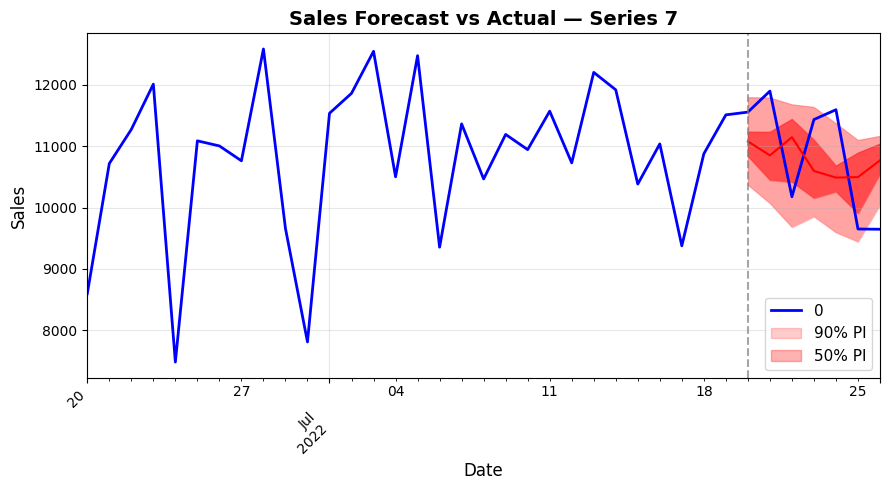

Plotting series 8...


/home/snig/miniconda3/envs/lag-llama-env/lib/python3.12/site-packages/gluonts/model/forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


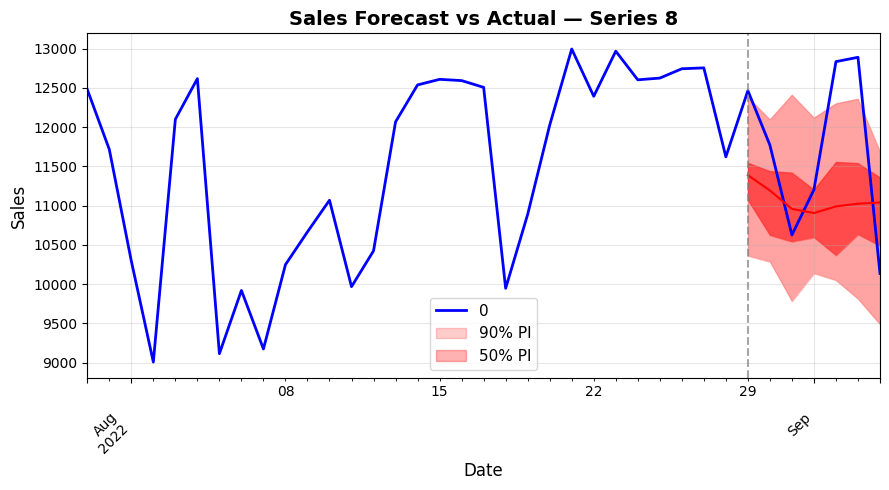

Plotting series 9...


/home/snig/miniconda3/envs/lag-llama-env/lib/python3.12/site-packages/gluonts/model/forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


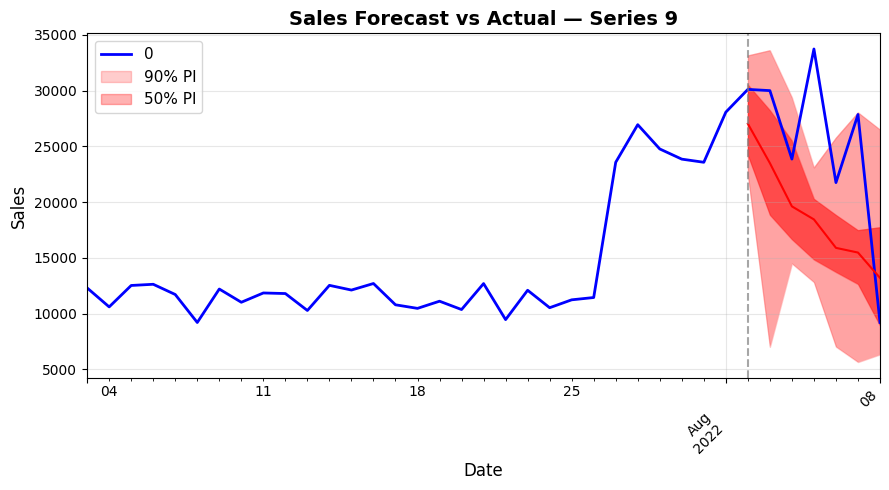

Plotting series 10...


/home/snig/miniconda3/envs/lag-llama-env/lib/python3.12/site-packages/gluonts/model/forecast.py:327: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


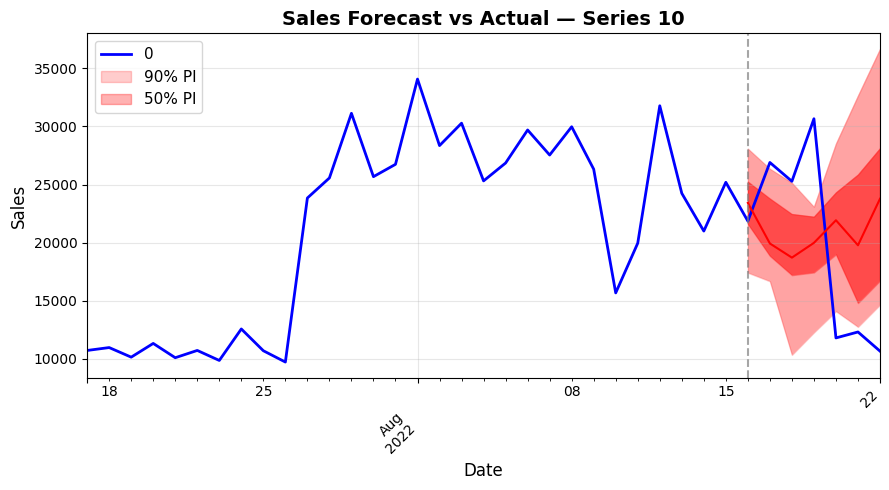

Plotting completed!

FORECAST STATISTICS

Series 1:
  Actual data points: 37
  Forecast length: 7
  Last actual value: 10166
  First forecast value: 10581
  Forecast range: 10271 - 11183

Series 2:
  Actual data points: 37
  Forecast length: 7
  Last actual value: 11648
  First forecast value: 11640
  Forecast range: 10412 - 11640

Series 3:
  Actual data points: 37
  Forecast length: 7
  Last actual value: 10095
  First forecast value: 10243
  Forecast range: 10243 - 11008

Series 4:
  Actual data points: 37
  Forecast length: 7
  Last actual value: 11631
  First forecast value: 12065
  Forecast range: 10461 - 12065

Series 5:
  Actual data points: 37
  Forecast length: 7
  Last actual value: 10755
  First forecast value: 10691
  Forecast range: 10620 - 10908

Series 6:
  Actual data points: 37
  Forecast length: 7
  Last actual value: 12666
  First forecast value: 12454
  Forecast range: 10717 - 12454

Series 7:
  Actual data points: 37
  Forecast length: 7
  Last actual value: 11510

/tmp/ipykernel_260084/3180933633.py:128: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"  Last actual value: {float(actual_values.iloc[-prediction_length-1]):.0f}")


In [20]:
import matplotlib.pyplot as plt
from itertools import islice

# Enable matplotlib inline for Jupyter
%matplotlib inline

# Generate fresh predictions for plotting (since iterators were consumed by evaluator)
print("Generating fresh predictions for plotting...")
forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds,
    predictor=predictor,
    num_samples=20
)

# Convert iterators to lists
forecast_list = list(forecast_it)
ts_list = list(ts_it)

# Debug: Check if we have data
print(f"Number of forecasts: {len(forecast_list)}")
print(f"Number of time series: {len(ts_list)}")
print(f"Context length: {context_length}")
print(f"Prediction length: {prediction_length}")

if len(forecast_list) == 0:
    print("ERROR: No forecasts generated!")
else:
    print("✓ Forecasts generated successfully")

# Plot forecasts
print(len(forecast_list))
num_series = 10 #len(forecast_list)  # Don't exceed available data
print(f"Plotting {num_series} series...")

for i, (ts, forecast) in enumerate(islice(zip(ts_list, forecast_list), num_series)):
    print(f"Plotting series {i+1}...")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(9, 5))
    
    # Plot actual time series (show more context)
    # Take last (context_length + prediction_length) points to show context + actual future
    actual_data = ts[-(context_length + prediction_length):]
    actual_data.plot(ax=ax, label="Actual", linewidth=2, color='blue')
    
    # Plot forecast with prediction intervals
    # forecast.plot(
    #     ax=ax,
    #     prediction_intervals=(50.0, 90.0),
    #     color="red",
    #     label="Forecast"
    # )

    # Plot forecast with prediction intervals
    forecast.plot(ax=ax, color="red")

    # Add prediction intervals manually if available
    try:
        # Get quantiles for prediction intervals
        q10 = forecast.quantile(0.05)  # 90% interval lower bound
        q90 = forecast.quantile(0.95)  # 90% interval upper bound
        q25 = forecast.quantile(0.25)  # 50% interval lower bound  
        q75 = forecast.quantile(0.75)  # 50% interval upper bound
        
        # Fill between quantiles
        ax.fill_between(forecast.index, q10, q90, alpha=0.2, color="red", label="90% PI")
        ax.fill_between(forecast.index, q25, q75, alpha=0.3, color="red", label="50% PI")
    except:
        print(f"Could not plot prediction intervals for series {i+1}")
    
    # Customize plot
    ax.set_title(f"Sales Forecast vs Actual — Series {i+1}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Sales", fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Add vertical line to separate history from forecast
    forecast_start = forecast.start_date
    ax.axvline(x=forecast_start, color='gray', linestyle='--', alpha=0.7, label='Forecast Start')
    
    # Rotate x-axis labels for better readability
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Save the plot
    # filename = f"forecast_series_{i+1}.png"
    # fig.savefig(filename, dpi=300, bbox_inches='tight')
    # print(f"Saved: {filename}")
    
    # Close figure to free memory
    plt.close(fig)

print("Plotting completed!")

# # Optional: Display some statistics about the forecasts
# print("\n" + "="*50)
# print("FORECAST STATISTICS")
# print("="*50)

# for i, (ts, forecast) in enumerate(islice(zip(ts_list, forecast_list), num_series)):
#     actual_values = ts[-(context_length + prediction_length):]
#     forecast_median = forecast.median
    
#     print(f"\nSeries {i+1}:")
#     print(f"  Actual data points: {len(actual_values)}")
#     print(f"  Forecast length: {len(forecast_median)}")
#     print(f"  Last actual value: {actual_values.iloc[-prediction_length-1]:.0f}")
#     print(f"  First forecast value: {forecast_median.iloc[0]:.0f}")
#     print(f"  Forecast range: {forecast_median.min():.0f} - {forecast_median.max():.0f}")

# Optional: Display some statistics about the forecasts
print("\n" + "="*50)
print("FORECAST STATISTICS")
print("="*50)

for i, (ts, forecast) in enumerate(islice(zip(ts_list, forecast_list), num_series)):
    actual_values = ts[-(context_length + prediction_length):]
    forecast_median = forecast.median
    
    print(f"\nSeries {i+1}:")
    print(f"  Actual data points: {len(actual_values)}")
    print(f"  Forecast length: {len(forecast_median)}")
    print(f"  Last actual value: {float(actual_values.iloc[-prediction_length-1]):.0f}")
    print(f"  First forecast value: {float(forecast_median[0]):.0f}")
    print(f"  Forecast range: {float(forecast_median.min()):.0f} - {float(forecast_median.max()):.0f}")